# LLaVA Deep Dive Study

이 노트북에서는 LLaVA(Large Language-and-Vision Assistant)의 구조를 더 깊이 이해하고, 멀티턴 대화 및 아키텍처 분석을 수행합니다.

## 목차
1. **모델 로드 및 구조 분석**: Vision Tower, Projector, LLM 연결 구조 확인
2. **데이터 흐름 시각화**: 이미지와 텍스트가 어떻게 임베딩되어 합쳐지는지 확인
3. **멀티턴 대화(Multi-turn Chat)**: 문맥을 유지하며 대화하는 방법 구현
4. **다양한 프롬프팅 실험**: OCR, 객체 탐지, 추론 등 다양한 태스크 실험

In [ ]:
import torch
from PIL import Image
import requests
from transformers import AutoProcessor, LlavaForConditionalGeneration

# 모델 ID 설정 (기본: LLaVA 1.5 7B)
model_id = "llava-hf/llava-1.5-7b-hf"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")

# 프로세서 및 모델 로드
# 4bit 로딩을 원하면 bitsandbytes 설치 후 load_in_4bit=True 옵션 사용 가능
processor = AutoProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    device_map="auto" if device == "cuda" else None,
    low_cpu_mem_usage=True
)

## 1. 모델 구조 분석 (Architecture Analysis)

LLaVA는 크게 세 부분으로 나뉩니다:
1. **Vision Tower (CLIP ViT)**: 이미지를 시각적 특징(feature)으로 변환
2. **Projector (MLP)**: 시각적 특징을 언어 모델의 임베딩 공간으로 투영
3. **Language Model (Llama/Vicuna)**: 텍스트와 시각적 특징을 입력받아 답변 생성

아래 코드로 각 모듈을 직접 확인해봅니다.

In [9]:
print("=== Whole Model Architecture ===")
print(model)

print("\n=== Vision Tower ===")
# 보통 model.vision_tower에 위치
print(model.vision_tower)

print("\n=== Multi-Modal Projector ===")
# model.multi_modal_projector에 위치
print(model.multi_modal_projector)

=== Whole Model Architecture ===
LlavaForConditionalGeneration(
  (model): LlavaModel(
    (vision_tower): CLIPVisionModel(
      (vision_model): CLIPVisionTransformer(
        (embeddings): CLIPVisionEmbeddings(
          (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
          (position_embedding): Embedding(577, 1024)
        )
        (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (encoder): CLIPEncoder(
          (layers): ModuleList(
            (0-23): 24 x CLIPEncoderLayer(
              (self_attn): CLIPAttention(
                (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
              )
              (layer_norm1): LayerNorm((1024,), eps=1e-05,

In [6]:
import torchinfo

print("=== Model Summary (torchinfo) ===")
print("모델의 각 레이어별 파라미터 수와 입출력 크기를 깔끔한 테이블로 확인합니다.")

summary_info = torchinfo.summary(
    model,
    # input_data=dict(inputs), # inputs가 정의되어 있다면 주석 해제
    col_names=["num_params", "trainable"],
    depth=2,
    verbose=0
)
print(summary_info)

=== Model Summary (torchinfo) ===
모델의 각 레이어별 파라미터 수와 입출력 크기를 깔끔한 테이블로 확인합니다.
Layer (type:depth-idx)                                                 Param #                   Trainable
LlavaForConditionalGeneration                                          --                        True
├─LlavaModel: 1-1                                                      --                        True
│    └─CLIPVisionModel: 2-1                                            303,507,456               True
│    └─LlavaMultiModalProjector: 2-2                                   20,979,712                True
│    └─LlamaModel: 2-3                                                 6,607,605,760             True
├─Linear: 1-2                                                          131,334,144               True
Total params: 7,063,427,072
Trainable params: 7,063,427,072
Non-trainable params: 0


![LLaVA Architecture](./llava_submodules.png)

## 2. 데이터 흐름 확인 (Data Flow)

이미지가 입력되었을 때 어떤 shape으로 변환되는지 확인해봅니다.
LLaVA 1.5는 CLIP ViT-L/14 336px를 사용하여, 이미지를 576개의 패치 토큰으로 변환합니다.

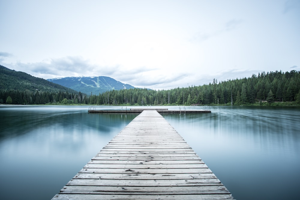

Input Image Shape: torch.Size([1, 3, 336, 336])
Vision Tower Output Shape: torch.Size([1, 577, 1024])
Projected Features Shape: torch.Size([1, 577, 4096])


In [11]:
# 테스트 이미지 로드
url = "https://llava-vl.github.io/static/images/view.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image.save("test_image.jpg")
display(image.resize((300, 200)))

# 전처리 확인
inputs = processor(text="USER: <image>\nDescribe this image.\nASSISTANT:", images=image, return_tensors="pt")
pixel_values = inputs.pixel_values
print(f"Input Image Shape: {pixel_values.shape}") # (Batch, Channel, Height, Width)

# Vision Tower 통과 후 Feature 확인
with torch.no_grad():
    # Vision Tower의 forward 메서드를 직접 호출하거나 모델 내부 메서드 활용
    # HF 구현체에서는 model.vision_tower(pixel_values) 등으로 호출 가능
    image_features = model.vision_tower(pixel_values.to(device, dtype=model.dtype))
    # hidden_states의 마지막 레이어 혹은 지정된 레이어 사용
    if isinstance(image_features, tuple):
        image_features = image_features.last_hidden_state
    elif hasattr(image_features, 'last_hidden_state'):
        image_features = image_features.last_hidden_state
        
    print(f"Vision Tower Output Shape: {image_features.shape}")
    
    # Projector 통과
    projected_features = model.multi_modal_projector(image_features)
    print(f"Projected Features Shape: {projected_features.shape}")

## 3. 멀티턴 대화 (Multi-turn Chat)

LLaVA는 대화 기록을 프롬프트에 누적하여 멀티턴 대화를 수행할 수 있습니다.
형식: `USER: <image>\n{질문1}\nASSISTANT: {답변1}\nUSER: {질문2}\nASSISTANT:`

In [12]:
def chat_with_llava(image, conversation_history, new_question):
    # 대화 기록 구성
    prompt = ""
    # 첫 번째 턴에만 <image> 토큰 포함
    if len(conversation_history) == 0:
        prompt = f"USER: <image>\n{new_question}\nASSISTANT:"
    else:
        # 이전 기록 합치기
        for turn in conversation_history:
            prompt += f"USER: {turn['user']}\nASSISTANT: {turn['assistant']}\n"
        # <image> 토큰은 맨 처음에만 있으면 됨 (구현에 따라 다를 수 있으나 보통 첫 턴에 포함)
        # 주의: HF Processor는 텍스트 전체를 처리하므로, 이미지가 포함된 전체 컨텍스트를 다시 넣을 때는 
        # <image> 토큰 위치를 신경써야 함. 여기서는 단순화를 위해 매번 전체 히스토리를 구성하되,
        # 첫 턴에만 <image>를 넣는 방식을 사용.
        
        # 재구성: 맨 앞에 <image>가 있는 첫 턴 + 나머지 턴
        first_turn = conversation_history[0]
        prompt = f"USER: <image>\n{first_turn['user']}\nASSISTANT: {first_turn['assistant']}\n"
        for turn in conversation_history[1:]:
            prompt += f"USER: {turn['user']}\nASSISTANT: {turn['assistant']}\n"
        prompt += f"USER: {new_question}\nASSISTANT:"

    inputs = processor(text=prompt, images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.inference_mode():
        output = model.generate(**inputs, max_new_tokens=200)
    
    decoded_output = processor.decode(output[0], skip_special_tokens=True)
    
    # 생성된 답변만 추출 (프롬프트 이후 부분)
    # 간단히 'ASSISTANT:' 마지막 등장 이후를 자르는 방식 사용
    response = decoded_output.split("ASSISTANT:")[-1].strip()
    return response

# 대화 테스트
history = []

# 질문 1
q1 = "What is in this image?"
a1 = chat_with_llava(image, history, q1)
print(f"Q1: {q1}\nA1: {a1}\n")
history.append({"user": q1, "assistant": a1})

# 질문 2
q2 = "Is there any water in the image?"
a2 = chat_with_llava(image, history, q2)
print(f"Q2: {q2}\nA2: {a2}\n")
history.append({"user": q2, "assistant": a2})

Q1: What is in this image?
A1: The image features a pier extending out over a large body of water, likely a lake. The pier is made of wood and has a bench on it, providing a place for people to sit and enjoy the view. The scene is set against a backdrop of mountains, adding to the picturesque atmosphere. The pier is situated near a forest, creating a serene and natural environment.

Q2: Is there any water in the image?
A2: Yes, there is water in the image, as the pier extends out over the large body of water.

